In [ ]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image
import os

spectrogram_path = "/content/drive/MyDrive/EEG CLASSFICIATION/3 Class Dataset/Spectogram"

for root, dirs, files in os.walk(spectrogram_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            with Image.open(file_path) as img:
                img.verify()  # Verify if the file is a valid image
        except Exception as e:
            print(f"Corrupt image detected: {file_path}, Error: {e}")


In [ ]:
import os

spectrogram_path = "/content/drive/MyDrive/EEG CLASSFICIATION/3 Class Dataset/Spectogram"

for root, dirs, files in os.walk(spectrogram_path):
    for file in files:
        file_path = os.path.join(root, file)
        if os.path.getsize(file_path) == 0:  # Check if file is empty
            print(f"Empty file detected: {file_path}")


In [ ]:
from PIL import Image

img_path = "/content/drive/MyDrive/EEG CLASSFICIATION/3 Class Dataset/Spectogram/Baseline/EEG01R1_Baseline.png"
img = Image.open(img_path)
img.show()


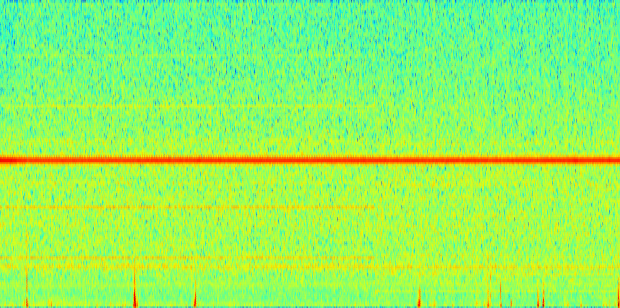

In [ ]:
from IPython.display import display
display(img)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Define ImageDataGenerator with augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80-20 Train-Validation Split
)

# Define paths to PAC and Spectrogram directories
PAC_PATH = "/content/drive/MyDrive/EEG CLASSFICIATION/3 Class Dataset/PAC"
SPECTROGRAM_PATH = "/content/drive/MyDrive/EEG CLASSFICIATION/3 Class Dataset/Spectogram"

# Training Generators (Ensure only 3 classes exist in the dataset folders)
spectrogram_train = datagen.flow_from_directory(
    SPECTROGRAM_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

pac_train = datagen.flow_from_directory(
    PAC_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation Generators
spectrogram_val = datagen.flow_from_directory(
    SPECTROGRAM_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

pac_val = datagen.flow_from_directory(
    PAC_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Print class indices to verify that only 3 classes are loaded
print("Spectrogram Class Indices:", spectrogram_train.class_indices)
print("PAC Class Indices:", pac_train.class_indices)


Found 178 images belonging to 3 classes.
Found 178 images belonging to 3 classes.
Found 44 images belonging to 3 classes.
Found 44 images belonging to 3 classes.
Spectrogram Class Indices: {'Baseline': 0, 'HVLT': 1, 'Stroop': 2}
PAC Class Indices: {'Baseline': 0, 'HVLT': 1, 'Stroop': 2}


In [ ]:
import numpy as np

# Convert images and labels into NumPy arrays
train_spectrograms, train_pacs, train_labels = [], [], []
val_spectrograms, val_pacs, val_labels = [], [], []

# Function to extract data (now correctly accumulates labels)
def extract_data(generator, image_list, label_list=None):
    temp_labels = []  # Temporary storage for labels
    for i in range(len(generator)):
        images, labels = generator[i]  # Get batch
        image_list.append(images)  # Append images
        if label_list is not None:
            temp_labels.append(labels)  # Collect labels for all batches

    # Convert labels to a numpy array once after all batches are collected
    if label_list is not None:
        label_list.append(np.vstack(temp_labels))

# Process training data
extract_data(spectrogram_train, train_spectrograms, train_labels)  # Extract labels here
extract_data(pac_train, train_pacs)  # Don't extract labels again

# Process validation data
extract_data(spectrogram_val, val_spectrograms, val_labels)  # Extract labels here
extract_data(pac_val, val_pacs)  # Don't extract labels again

# Convert lists to numpy arrays
train_spectrograms = np.vstack(train_spectrograms)
train_pacs = np.vstack(train_pacs)
train_labels = np.vstack(train_labels)  # Now correctly stores all labels

val_spectrograms = np.vstack(val_spectrograms)
val_pacs = np.vstack(val_pacs)
val_labels = np.vstack(val_labels)  # Now correctly stores all labels

# Print dataset shapes
print("Training Data Shapes:")
print("Spectrograms:", train_spectrograms.shape)  # (178, 224, 224, 3)
print("PACs:", train_pacs.shape)  # (178, 224, 224, 3)
print("Labels:", train_labels.shape)  # (178, 3) ✅ FIXED!

print("\nValidation Data Shapes:")
print("Spectrograms:", val_spectrograms.shape)  # (44, 224, 224, 3)
print("PACs:", val_pacs.shape)  # (44, 224, 224, 3)
print("Labels:", val_labels.shape)  # (44, 3) ✅ FIXED!


Training Data Shapes:
Spectrograms: (178, 224, 224, 3)
PACs: (178, 224, 224, 3)
Labels: (178, 3)

Validation Data Shapes:
Spectrograms: (44, 224, 224, 3)
PACs: (44, 224, 224, 3)
Labels: (44, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Input Shape
input_shape = (224, 224, 3)

# -------------------- Define Feature Extractor Function -------------------- #
def create_feature_extractor(input_tensor, name_prefix):
    # Create a NEW instance of MobileNetV2 with a unique name for each branch
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        name=f'{name_prefix}_mobilenetv2'  # Give a unique name to each instance
    )

    x = base_model(input_tensor)
    x = GlobalAveragePooling2D(name=f"{name_prefix}_GAP")(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01), name=f"{name_prefix}_Dense")(x)
    x = BatchNormalization(name=f"{name_prefix}_BatchNorm")(x)
    x = Dropout(0.5, name=f"{name_prefix}_Dropout")(x)
    return x

# -------------------- PAC Heatmap Branch -------------------- #
pac_input = Input(shape=input_shape, name="PAC_Input")
pac_features = create_feature_extractor(pac_input, "PAC")

# -------------------- Spectrogram Branch -------------------- #
spec_input = Input(shape=input_shape, name="Spectrogram_Input")
spec_features = create_feature_extractor(spec_input, "Spec")

# -------------------- Concatenate Features -------------------- #
merged = Concatenate(name="Feature_Concat")([pac_features, spec_features])
merged = Dense(512, activation='relu', kernel_regularizer=l2(0.01), name="Merged_Dense")(merged)
merged = BatchNormalization(name="Merged_BatchNorm")(merged)
merged = Dropout(0.5, name="Merged_Dropout")(merged)

# Final Output Layer (3 Classes)
output = Dense(3, activation='softmax', name="Output")(merged)

# Create Model
model = Model(inputs=[pac_input, spec_input], outputs=output)

# Compile Model
optimizer = Adam(learning_rate=0.0001)  # Lower LR for stable training
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Model Summary
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ PAC_Input (InputLayer)    │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Spectrogram_Input         │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ PAC_mobilenetv2           │ (None, 7, 7, 1280)     │      2,257,984 │ PAC_Input[0][0]        │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Spec_mobilenetv2          │ (None, 7, 7, 1280)     │      2,257,984 │ Spectrogram_Input[0][… │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ PAC_GAP                   │ (None, 1280)           │              0 │ PAC_mobilenetv2[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Spec_GAP                  │ (None, 1280)           │              0 │ Spec_mobilenetv2[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ PAC_Dense (Dense)         │ (None, 256)            │        327,936 │ PAC_GAP[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Spec_Dense (Dense)        │ (None, 256)            │        327,936 │ Spec_GAP[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ PAC_BatchNorm             │ (None, 256)            │          1,024 │ PAC_Dense[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Spec_BatchNorm            │ (None, 256)            │          1,024 │ Spec_Dense[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ PAC_Dropout (Dropout)     │ (None, 256)            │              0 │ PAC_BatchNorm[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Spec_Dropout (Dropout)    │ (None, 256)            │              0 │ Spec_BatchNorm[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Feature_Concat            │ (None, 512)            │              0 │ PAC_Dropout[0][0],     │
│ (Concatenate)             │                        │                │ Spec_Dropout[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Merged_Dense (Dense)      │ (None, 512)            │        262,656 │ Feature_Concat[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Merged_BatchNorm          │ (None, 512)            │          2,048 │ Merged_Dense[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 5,440,131 (20.75 MB)

 Trainable params: 5,369,859 (20.48 MB)

 Non-trainable params: 70,272 (274.50 KB)

In [ ]:
model.fit(
    [train_pacs, train_spectrograms], train_labels,
    validation_data=([val_pacs, val_spectrograms], val_labels),
    epochs=25,
    batch_size=32,
    callbacks=[lr_scheduler]
)


Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 140s 10s/step - accuracy: 0.3270 - loss: 15.6371 - val_accuracy: 0.3409 - val_loss: 15.1892 - learning_rate: 1.0000e-04
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 59s 242ms/step - accuracy: 0.5240 - loss: 14.9444 - val_accuracy: 0.3409 - val_loss: 15.0956 - learning_rate: 1.0000e-04
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.5998 - loss: 14.6907 - val_accuracy: 0.3409 - val_loss: 14.9935 - learning_rate: 1.0000e-04
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.7054 - loss: 14.2812 - val_accuracy: 0.3409 - val_loss: 14.9300 - learning_rate: 1.0000e-04
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.7664 - loss: 14.0647 - val_accuracy: 0.3636 - val_loss: 14.8833 - learning_rate: 1.0000e-04
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.8075 - loss: 13.9657 - val_accuracy: 0.3636 - val_loss: 14.8700 - learning_rate: 1.0000e-04
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0

#Try 2

Stage 1: Training classification layers only...
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3739 - loss: 5.4668  
Epoch 1: val_accuracy improved from -inf to 0.29545, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.3678 - loss: 5.4842 - val_accuracy: 0.2955 - val_loss: 5.2759 - learning_rate: 1.0000e-04
Epoch 2/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3494 - loss: 5.3417
Epoch 2: val_accuracy did not improve from 0.29545
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.3491 - loss: 5.3315 - val_accuracy: 0.2955 - val_loss: 5.1456 - learning_rate: 1.0000e-04
Epoch 3/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4748 - loss: 5.0134
Epoch 3: val_accuracy did not improve from 0.29545
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.4675 - loss: 5.0182 - val_accuracy: 0.2955 - val_loss: 5.0374 - learning_rate: 1.0000e-04
Epoch 4/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3882 - loss: 5.0440
Epoch 4: val_accuracy improved from 0.29545 to 0.36364, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - accuracy: 0.4170 - loss: 4.9822 - val_accuracy: 0.3636 - val_loss: 4.9240 - learning_rate: 1.0000e-04
Epoch 5/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4483 - loss: 4.8656
Epoch 5: val_accuracy did not improve from 0.36364
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.4535 - loss: 4.8615 - val_accuracy: 0.3636 - val_loss: 4.8254 - learning_rate: 1.0000e-04
Epoch 6/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5691 - loss: 4.7469
Epoch 6: val_accuracy improved from 0.36364 to 0.40909, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.5734 - loss: 4.7424 - val_accuracy: 0.4091 - val_loss: 4.7363 - learning_rate: 1.0000e-04
Epoch 7/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5199 - loss: 4.5950
Epoch 7: val_accuracy improved from 0.40909 to 0.50000, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.5174 - loss: 4.5979 - val_accuracy: 0.5000 - val_loss: 4.6481 - learning_rate: 1.0000e-04
Epoch 8/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5285 - loss: 4.7497
Epoch 8: val_accuracy improved from 0.50000 to 0.54545, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.5348 - loss: 4.7189 - val_accuracy: 0.5455 - val_loss: 4.5795 - learning_rate: 1.0000e-04
Epoch 9/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6786 - loss: 4.3414
Epoch 9: val_accuracy did not improve from 0.54545
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6645 - loss: 4.3629 - val_accuracy: 0.5227 - val_loss: 4.5142 - learning_rate: 1.0000e-04
Epoch 10/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6294 - loss: 4.3578
Epoch 10: val_accuracy improved from 0.54545 to 0.56818, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.6277 - loss: 4.3493 - val_accuracy: 0.5682 - val_loss: 4.4600 - learning_rate: 1.0000e-04
Epoch 11/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6170 - loss: 4.3576
Epoch 11: val_accuracy did not improve from 0.56818
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.6205 - loss: 4.3469 - val_accuracy: 0.5682 - val_loss: 4.4113 - learning_rate: 1.0000e-04
Epoch 12/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6689 - loss: 4.2494
Epoch 12: val_accuracy did not improve from 0.56818
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6672 - loss: 4.2500 - val_accuracy: 0.5682 - val_loss: 4.3645 - learning_rate: 1.0000e-04
Epoch 13/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6782 - loss: 4.2883
Epoch 13: val_accuracy did not improve from 0.56818
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.6723 - loss: 4.2767 - val_accuracy: 0.5682 - val_loss: 4.3190 - learning_rate: 1.0000e-04
Epoch 14/50
5/6 ━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.6197 - loss: 4.4210 - val_accuracy: 0.5909 - val_loss: 4.2732 - learning_rate: 1.0000e-04
Epoch 15/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7367 - loss: 4.0787
Epoch 15: val_accuracy did not improve from 0.59091
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.7284 - loss: 4.0722 - val_accuracy: 0.5909 - val_loss: 4.2341 - learning_rate: 1.0000e-04
Epoch 16/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6677 - loss: 4.1372
Epoch 16: val_accuracy improved from 0.59091 to 0.61364, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.6824 - loss: 4.1151 - val_accuracy: 0.6136 - val_loss: 4.1961 - learning_rate: 1.0000e-04
Epoch 17/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6853 - loss: 4.0940
Epoch 17: val_accuracy improved from 0.61364 to 0.65909, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.6902 - loss: 4.0987 - val_accuracy: 0.6591 - val_loss: 4.1569 - learning_rate: 1.0000e-04
Epoch 18/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7359 - loss: 4.0704
Epoch 18: val_accuracy improved from 0.65909 to 0.68182, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.7375 - loss: 4.0761 - val_accuracy: 0.6818 - val_loss: 4.1170 - learning_rate: 1.0000e-04
Epoch 19/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7871 - loss: 3.9925
Epoch 19: val_accuracy did not improve from 0.68182
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7805 - loss: 3.9930 - val_accuracy: 0.6818 - val_loss: 4.0897 - learning_rate: 1.0000e-04
Epoch 20/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7975 - loss: 3.8911
Epoch 20: val_accuracy did not improve from 0.68182
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.8024 - loss: 3.8787 - val_accuracy: 0.6818 - val_loss: 4.0665 - learning_rate: 1.0000e-04
Epoch 21/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7660 - loss: 3.9298
Epoch 21: val_accuracy did not improve from 0.68182
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7687 - loss: 3.9224 - val_accuracy: 0.6818 - val_loss: 4.0399 - learning_rate: 1.0000e-04
Epoch 22/50
5/6 ━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - accuracy: 0.8287 - loss: 3.7013 - val_accuracy: 0.7045 - val_loss: 3.8690 - learning_rate: 1.0000e-04
Epoch 28/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7792 - loss: 3.7828
Epoch 28: val_accuracy did not improve from 0.70455
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7748 - loss: 3.7972 - val_accuracy: 0.7045 - val_loss: 3.8410 - learning_rate: 1.0000e-04
Epoch 29/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7155 - loss: 3.8216
Epoch 29: val_accuracy did not improve from 0.70455
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.7294 - loss: 3.8021 - val_accuracy: 0.7045 - val_loss: 3.8176 - learning_rate: 1.0000e-04
Epoch 30/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7983 - loss: 3.7195
Epoch 30: val_accuracy did not improve from 0.70455
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.7966 - loss: 3.7137 - val_accuracy: 0.7045 - val_loss: 3.8006 - learning_rate: 1.0000e-04
Epoch 31/50
5/6 ━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.8884 - loss: 3.5388 - val_accuracy: 0.7500 - val_loss: 3.7030 - learning_rate: 1.0000e-04
Epoch 35/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8221 - loss: 3.5851
Epoch 35: val_accuracy did not improve from 0.75000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.8264 - loss: 3.5872 - val_accuracy: 0.7500 - val_loss: 3.6763 - learning_rate: 1.0000e-04
Epoch 36/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8246 - loss: 3.6389
Epoch 36: val_accuracy did not improve from 0.75000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.8298 - loss: 3.6255 - val_accuracy: 0.7273 - val_loss: 3.6594 - learning_rate: 1.0000e-04
Epoch 37/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8824 - loss: 3.5224
Epoch 37: val_accuracy did not improve from 0.75000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8743 - loss: 3.5366 - val_accuracy: 0.7273 - val_loss: 3.6456 - learning_rate: 1.0000e-04
Epoch 38/50
5/6 ━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.9060 - loss: 3.3004 - val_accuracy: 0.7727 - val_loss: 3.4582 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 50.
Stage 2: Fine-tuning model...
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7064 - loss: 3.8739  
Epoch 1: val_accuracy did not improve from 0.77273
6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7050 - loss: 3.8801 - val_accuracy: 0.7500 - val_loss: 3.4877 - learning_rate: 1.0000e-05
Epoch 2/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6577 - loss: 3.8625
Epoch 2: val_accuracy did not improve from 0.77273
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.6512 - loss: 3.8823 - val_accuracy: 0.7500 - val_loss: 3.5203 - learning_rate: 1.0000e-05
Epoch 3/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7391 - loss: 3.8357
Epoch 3: val_accuracy did not improve from 0.77273
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7366 - loss: 3.8366 - val_acc

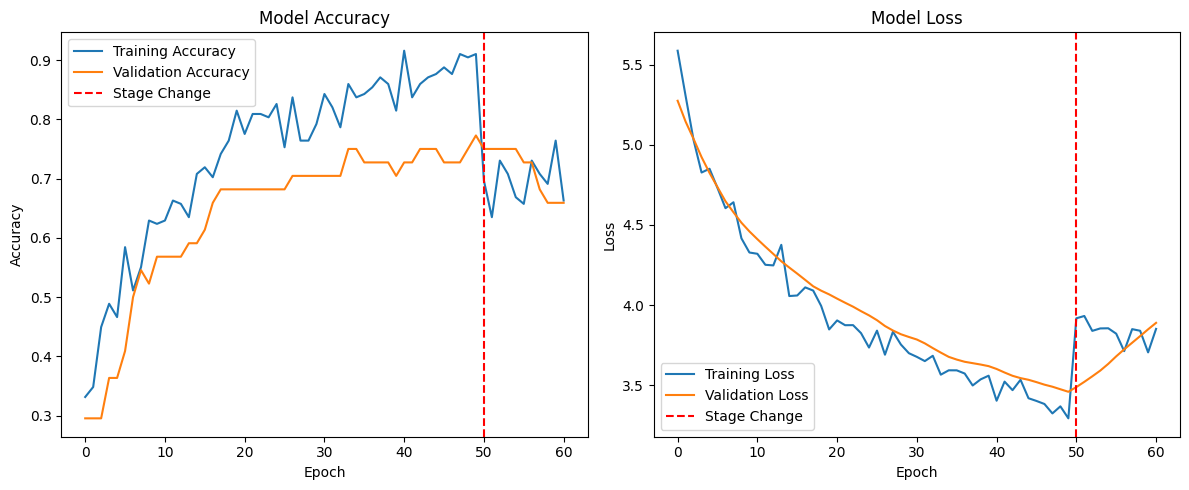

No test data available for evaluation


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

# -------------------- Define Model Parameters -------------------- #
input_shape = (224, 224, 3)
num_classes = 3  # 🔹 Changed from 9 to 3 classes

# -------------------- Define Feature Extractor Function -------------------- #
def create_feature_extractor(input_tensor, name_prefix, trainable_layers=0):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        name=f'{name_prefix}_mobilenetv2'
    )

    # Freeze most layers, unfreeze a few
    for layer in base_model.layers:
        layer.trainable = False

    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True

    x = base_model(input_tensor)
    x = GlobalAveragePooling2D(name=f"{name_prefix}_GAP")(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.005), name=f"{name_prefix}_Dense")(x)
    x = BatchNormalization(name=f"{name_prefix}_BatchNorm")(x)
    x = Dropout(0.4, name=f"{name_prefix}_Dropout")(x)
    return x

# -------------------- PAC Heatmap Branch -------------------- #
pac_input = Input(shape=input_shape, name="PAC_Input")
pac_features = create_feature_extractor(pac_input, "PAC", trainable_layers=10)

# -------------------- Spectrogram Branch -------------------- #
spec_input = Input(shape=input_shape, name="Spectrogram_Input")
spec_features = create_feature_extractor(spec_input, "Spec", trainable_layers=10)

# -------------------- Concatenate Features -------------------- #
merged = Concatenate(name="Feature_Concat")([pac_features, spec_features])
merged = Dense(256, activation='relu', kernel_regularizer=l2(0.005), name="Merged_Dense")(merged)
merged = BatchNormalization(name="Merged_BatchNorm")(merged)
merged = Dropout(0.4, name="Merged_Dropout")(merged)

# 🔹 Final Output Layer (3 Classes)
output = Dense(num_classes, activation='softmax', name="Output")(merged)

# Create Model
model = Model(inputs=[pac_input, spec_input], outputs=output)

# Compile Model
optimizer = Adam(learning_rate=0.00005)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -------------------- TF.data Dataset Creation -------------------- #
def create_dataset(pac_data, spec_data, labels, batch_size=32, is_training=True):
    input_pairs = (pac_data, spec_data)
    dataset = tf.data.Dataset.from_tensor_slices((input_pairs, labels))

    if is_training:
        dataset = dataset.shuffle(buffer_size=len(labels))

        def augment(inputs, label):
            pac, spec = inputs
            def apply_augmentation(image):
                image = tf.image.random_flip_left_right(image)
                image = tf.image.random_brightness(image, max_delta=0.1)
                image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
                return image

            aug_pac = apply_augmentation(pac)
            aug_spec = apply_augmentation(spec)
            return (aug_pac, aug_spec), label

        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# -------------------- Callbacks -------------------- #
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_dual_input_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# -------------------- Multi-Stage Training Strategy -------------------- #
# 🔹 Use the correct dataset variables
train_dataset = create_dataset(train_pacs, train_spectrograms, train_labels, batch_size=32, is_training=True)
val_dataset = create_dataset(val_pacs, val_spectrograms, val_labels, batch_size=32, is_training=False)

# Stage 1: Train only the classification layers
for layer in model.layers:
    if 'mobilenetv2' in layer.name:
        layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Stage 1: Training classification layers only...")
history1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint],
    verbose=1
)

# Stage 2: Fine-tune MobileNetV2 along with classification layers
for layer in model.layers:
    layer.trainable = True
    if 'mobilenetv2' in layer.name:
        for sublayer in layer.layers[:-10]:  # Unfreeze only last 10 layers
            sublayer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Stage 2: Fine-tuning model...")
history2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint],
    verbose=1
)

# -------------------- Plot Training History -------------------- #
combined_history = {
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
    'loss': history1.history['loss'] + history2.history['loss'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss']
}

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.axvline(x=len(history1.history['accuracy']), color='r', linestyle='--', label='Stage Change')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.axvline(x=len(history1.history['loss']), color='r', linestyle='--', label='Stage Change')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

plot_training_history(combined_history)

# -------------------- Model Evaluation (if test data is available) -------------------- #
try:
    test_dataset = create_dataset(test_pacs, test_spectrograms, test_labels, batch_size=32, is_training=False)
    test_loss, test_acc = model.evaluate(test_dataset, verbose=1)
    print(f"Test Accuracy: {test_acc:.4f}")
except NameError:
    print("No test data available for evaluation")


In [ ]:
best_val_acc1 = max(history1.history['val_accuracy'])  # Stage 1 best validation accuracy
best_val_acc2 = max(history2.history['val_accuracy'])  # Stage 2 best validation accuracy
best_val_acc = max(best_val_acc1, best_val_acc2)  # Overall best validation accuracy
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


Best Validation Accuracy: 0.7727


2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 8s/step


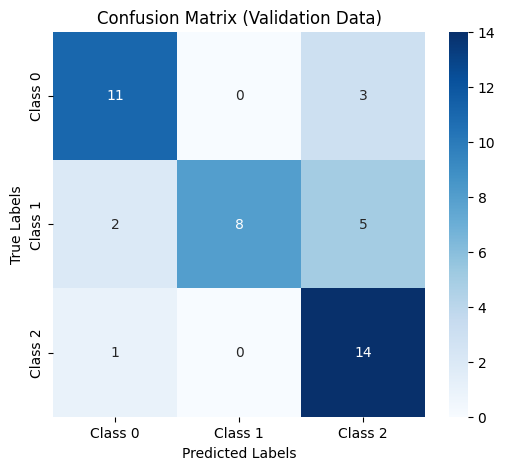

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.79      0.79      0.79        14
     Class 1       1.00      0.53      0.70        15
     Class 2       0.64      0.93      0.76        15

    accuracy                           0.75        44
   macro avg       0.81      0.75      0.75        44
weighted avg       0.81      0.75      0.75        44



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict on validation data
y_val_probs = model.predict(val_dataset)  # Get predicted probabilities
y_pred = np.argmax(y_val_probs, axis=1)  # Convert probabilities to class labels

# Extract true labels from validation dataset
y_true = np.concatenate([y.numpy() for _, y in val_dataset])  # Convert tensors to numpy
y_true = np.argmax(y_true, axis=1)  # Convert one-hot labels to class labels

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Validation Data)")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))


In [ ]:
task_labels = [
    "Baseline","HVLT","Stroop",
]

# Generate classification report with actual task names
class_report = classification_report(y_true, y_pred, target_names=task_labels)
print("Updated Classification Report:\n", class_report)


Updated Classification Report:
               precision    recall  f1-score   support

    Baseline       0.79      0.79      0.79        14
        HVLT       1.00      0.53      0.70        15
      Stroop       0.64      0.93      0.76        15

    accuracy                           0.75        44
   macro avg       0.81      0.75      0.75        44
weighted avg       0.81      0.75      0.75        44



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


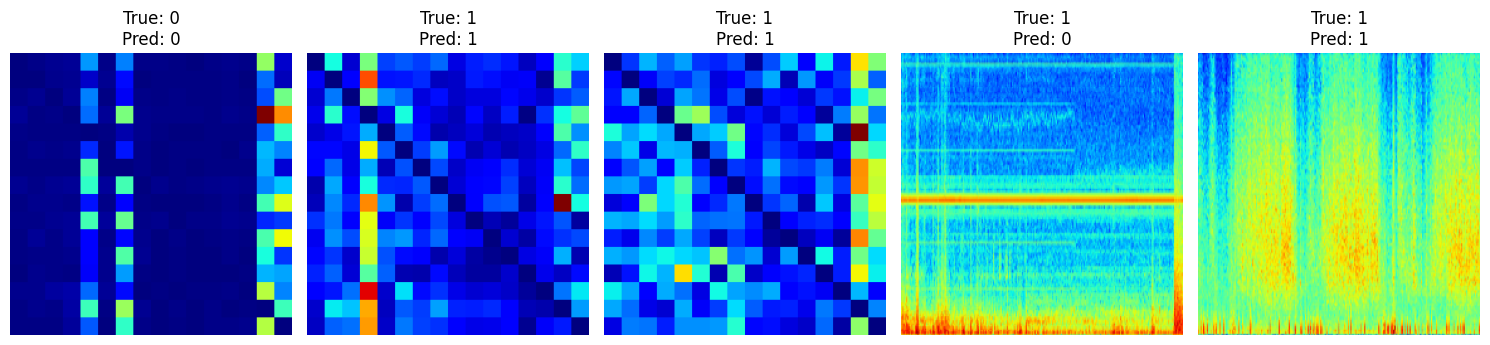

In [ ]:
import random

def predict_random_samples(num_samples=5):
    indices = random.sample(range(len(Y_val)), num_samples)  # Pick random indices

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, idx in enumerate(indices):
        pac_img = X_val_pac[idx]
        spec_img = X_val_spectrogram[idx]
        true_label = np.argmax(Y_val[idx])

        # Predict
        pred = model.predict([np.expand_dims(pac_img, axis=0), np.expand_dims(spec_img, axis=0)])
        pred_label = np.argmax(pred)

        # Show image
        axes[i].imshow(spec_img)  # Show spectrogram image (or PAC if you prefer)
        axes[i].axis('off')
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")

    plt.tight_layout()
    plt.show()

# Run the function
predict_random_samples(num_samples=5)


FINAL ONE WITH BEST ACCURACY


Stage 1: Training classification layers only...
Epoch 1/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2925 - loss: 5.7085  
Epoch 1: val_accuracy improved from -inf to 0.31818, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.2940 - loss: 5.6812 - val_accuracy: 0.3182 - val_loss: 4.8012 - learning_rate: 1.0000e-04
Epoch 2/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3738 - loss: 5.3260
Epoch 2: val_accuracy improved from 0.31818 to 0.36364, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.3890 - loss: 5.2688 - val_accuracy: 0.3636 - val_loss: 4.7270 - learning_rate: 1.0000e-04
Epoch 3/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4363 - loss: 4.8975
Epoch 3: val_accuracy improved from 0.36364 to 0.45455, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - accuracy: 0.4320 - loss: 4.9205 - val_accuracy: 0.4545 - val_loss: 4.6603 - learning_rate: 1.0000e-04
Epoch 4/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4715 - loss: 4.8180
Epoch 4: val_accuracy improved from 0.45455 to 0.54545, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.4764 - loss: 4.8108 - val_accuracy: 0.5455 - val_loss: 4.6001 - learning_rate: 1.0000e-04
Epoch 5/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4667 - loss: 4.9186
Epoch 5: val_accuracy did not improve from 0.54545
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.4650 - loss: 4.9040 - val_accuracy: 0.5455 - val_loss: 4.5396 - learning_rate: 1.0000e-04
Epoch 6/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5011 - loss: 4.6721
Epoch 6: val_accuracy did not improve from 0.54545
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.5056 - loss: 4.6617 - val_accuracy: 0.5455 - val_loss: 4.4831 - learning_rate: 1.0000e-04
Epoch 7/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5575 - loss: 4.4892
Epoch 7: val_accuracy improved from 0.54545 to 0.56818, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.5700 - loss: 4.4707 - val_accuracy: 0.5682 - val_loss: 4.4369 - learning_rate: 1.0000e-04
Epoch 8/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6728 - loss: 4.4688
Epoch 8: val_accuracy did not improve from 0.56818
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.6620 - loss: 4.4748 - val_accuracy: 0.5682 - val_loss: 4.3998 - learning_rate: 1.0000e-04
Epoch 9/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6160 - loss: 4.3338
Epoch 9: val_accuracy improved from 0.56818 to 0.63636, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.6166 - loss: 4.3320 - val_accuracy: 0.6364 - val_loss: 4.3533 - learning_rate: 1.0000e-04
Epoch 10/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5530 - loss: 4.3695
Epoch 10: val_accuracy did not improve from 0.63636
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5539 - loss: 4.3796 - val_accuracy: 0.6364 - val_loss: 4.3137 - learning_rate: 1.0000e-04
Epoch 11/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6473 - loss: 4.2205
Epoch 11: val_accuracy improved from 0.63636 to 0.65909, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.6469 - loss: 4.2305 - val_accuracy: 0.6591 - val_loss: 4.2815 - learning_rate: 1.0000e-04
Epoch 12/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6732 - loss: 4.2648
Epoch 12: val_accuracy improved from 0.65909 to 0.68182, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.6831 - loss: 4.2484 - val_accuracy: 0.6818 - val_loss: 4.2544 - learning_rate: 1.0000e-04
Epoch 13/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6017 - loss: 4.4438
Epoch 13: val_accuracy did not improve from 0.68182
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.6240 - loss: 4.3782 - val_accuracy: 0.6364 - val_loss: 4.2273 - learning_rate: 1.0000e-04
Epoch 14/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6460 - loss: 4.1016
Epoch 14: val_accuracy did not improve from 0.68182
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6557 - loss: 4.1199 - val_accuracy: 0.6591 - val_loss: 4.2049 - learning_rate: 1.0000e-04
Epoch 15/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7303 - loss: 4.2193
Epoch 15: val_accuracy did not improve from 0.68182
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.7335 - loss: 4.2087 - val_accuracy: 0.6591 - val_loss: 4.1727 - learning_rate: 1.0000e-04
Epoch 16/75
5/6 ━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.8201 - loss: 3.6939 - val_accuracy: 0.7045 - val_loss: 3.9541 - learning_rate: 1.0000e-04
Epoch 24/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8967 - loss: 3.6222
Epoch 24: val_accuracy improved from 0.70455 to 0.75000, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.8812 - loss: 3.6415 - val_accuracy: 0.7500 - val_loss: 3.9209 - learning_rate: 1.0000e-04
Epoch 25/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8957 - loss: 3.6477
Epoch 25: val_accuracy did not improve from 0.75000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8790 - loss: 3.6781 - val_accuracy: 0.7500 - val_loss: 3.9000 - learning_rate: 1.0000e-04
Epoch 26/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8222 - loss: 3.6820
Epoch 26: val_accuracy did not improve from 0.75000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8152 - loss: 3.6884 - val_accuracy: 0.7500 - val_loss: 3.8868 - learning_rate: 1.0000e-04
Epoch 27/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8059 - loss: 3.7429
Epoch 27: val_accuracy did not improve from 0.75000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8068 - loss: 3.7343 - val_accuracy: 0.7500 - val_loss: 3.8643 - learning_rate: 1.0000e-04
Epoch 28/75
5/6 ━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.7974 - loss: 3.7554 - val_accuracy: 0.7727 - val_loss: 3.7730 - learning_rate: 1.0000e-04
Epoch 32/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8416 - loss: 3.5308
Epoch 32: val_accuracy did not improve from 0.77273
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8387 - loss: 3.5405 - val_accuracy: 0.7727 - val_loss: 3.7495 - learning_rate: 1.0000e-04
Epoch 33/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8602 - loss: 3.5365
Epoch 33: val_accuracy improved from 0.77273 to 0.79545, saving model to best_dual_input_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.8632 - loss: 3.5361 - val_accuracy: 0.7955 - val_loss: 3.7312 - learning_rate: 1.0000e-04
Epoch 34/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8806 - loss: 3.4935
Epoch 34: val_accuracy did not improve from 0.79545
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.8858 - loss: 3.4914 - val_accuracy: 0.7955 - val_loss: 3.7105 - learning_rate: 1.0000e-04
Epoch 35/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8692 - loss: 3.5465
Epoch 35: val_accuracy did not improve from 0.79545
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8744 - loss: 3.5272 - val_accuracy: 0.7955 - val_loss: 3.6959 - learning_rate: 1.0000e-04
Epoch 36/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8477 - loss: 3.4875
Epoch 36: val_accuracy did not improve from 0.79545
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8495 - loss: 3.4850 - val_accuracy: 0.7955 - val_loss: 3.6808 - learning_rate: 1.0000e-04
Epoch 37/75
5/6 ━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.8979 - loss: 3.3301 - val_accuracy: 0.8182 - val_loss: 3.5632 - learning_rate: 1.0000e-04
Epoch 45/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8604 - loss: 3.3738
Epoch 45: val_accuracy did not improve from 0.81818
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.8650 - loss: 3.3655 - val_accuracy: 0.8182 - val_loss: 3.5492 - learning_rate: 1.0000e-04
Epoch 46/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8797 - loss: 3.3377
Epoch 46: val_accuracy did not improve from 0.81818
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8787 - loss: 3.3371 - val_accuracy: 0.7955 - val_loss: 3.5393 - learning_rate: 1.0000e-04
Epoch 47/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9044 - loss: 3.2667
Epoch 47: val_accuracy did not improve from 0.81818
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9060 - loss: 3.2696 - val_accuracy: 0.8182 - val_loss: 3.5270 - learning_rate: 1.0000e-04
Epoch 48/75
5/6 ━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.8736 - loss: 3.2684 - val_accuracy: 0.8409 - val_loss: 3.4637 - learning_rate: 1.0000e-04
Epoch 51/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9348 - loss: 3.2254
Epoch 51: val_accuracy did not improve from 0.84091
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9277 - loss: 3.2390 - val_accuracy: 0.8409 - val_loss: 3.4383 - learning_rate: 1.0000e-04
Epoch 52/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9253 - loss: 3.1882
Epoch 52: val_accuracy did not improve from 0.84091
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9274 - loss: 3.1834 - val_accuracy: 0.8182 - val_loss: 3.4214 - learning_rate: 1.0000e-04
Epoch 53/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9282 - loss: 3.2722
Epoch 53: val_accuracy did not improve from 0.84091
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9279 - loss: 3.2630 - val_accuracy: 0.8409 - val_loss: 3.4088 - learning_rate: 1.0000e-04
Epoch 54/75
5/6 ━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.9321 - loss: 3.1083 - val_accuracy: 0.8636 - val_loss: 3.3952 - learning_rate: 1.0000e-04
Epoch 59/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9198 - loss: 3.1158
Epoch 59: val_accuracy did not improve from 0.86364
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9218 - loss: 3.1171 - val_accuracy: 0.8636 - val_loss: 3.3756 - learning_rate: 1.0000e-04
Epoch 60/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9655 - loss: 3.0648
Epoch 60: val_accuracy did not improve from 0.86364
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9609 - loss: 3.0816 - val_accuracy: 0.8636 - val_loss: 3.3588 - learning_rate: 1.0000e-04
Epoch 61/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9018 - loss: 3.1702
Epoch 61: val_accuracy did not improve from 0.86364
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9058 - loss: 3.1595 - val_accuracy: 0.8636 - val_loss: 3.3595 - learning_rate: 1.0000e-04
Epoch 62/75
5/6 ━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.9518 - loss: 2.9908 - val_accuracy: 0.8864 - val_loss: 3.2465 - learning_rate: 1.0000e-04
Epoch 74/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9526 - loss: 2.9336
Epoch 74: val_accuracy did not improve from 0.88636
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9485 - loss: 2.9421 - val_accuracy: 0.8636 - val_loss: 3.2332 - learning_rate: 1.0000e-04
Epoch 75/75
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9649 - loss: 2.9226
Epoch 75: val_accuracy did not improve from 0.88636
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9637 - loss: 2.9232 - val_accuracy: 0.8636 - val_loss: 3.2197 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 75.
Stage 2: Fine-tuning model...
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7145 - loss: 3.4685  
Epoch 1: val_accuracy did not improve from 0.88636
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.7071 - loss: 3.4880 - va

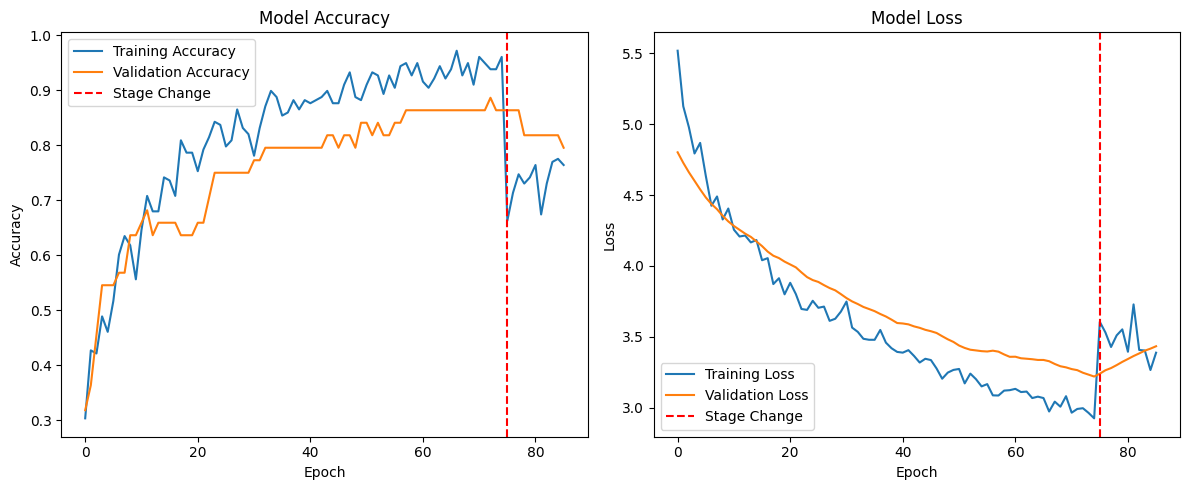

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

# -------------------- Define Model Parameters -------------------- #
input_shape = (224, 224, 3)
num_classes = 3  # 🔹 Changed from 9 to 3 classes

# -------------------- Define Feature Extractor Function -------------------- #
def create_feature_extractor(input_tensor, name_prefix, trainable_layers=0):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        name=f'{name_prefix}_mobilenetv2'
    )

    # Freeze most layers, unfreeze a few
    for layer in base_model.layers:
        layer.trainable = False

    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True

    x = base_model(input_tensor)
    x = GlobalAveragePooling2D(name=f"{name_prefix}_GAP")(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.005), name=f"{name_prefix}_Dense")(x)
    x = BatchNormalization(name=f"{name_prefix}_BatchNorm")(x)
    x = Dropout(0.4, name=f"{name_prefix}_Dropout")(x)
    return x

# -------------------- PAC Heatmap Branch -------------------- #
pac_input = Input(shape=input_shape, name="PAC_Input")
pac_features = create_feature_extractor(pac_input, "PAC", trainable_layers=10)

# -------------------- Spectrogram Branch -------------------- #
spec_input = Input(shape=input_shape, name="Spectrogram_Input")
spec_features = create_feature_extractor(spec_input, "Spec", trainable_layers=10)

# -------------------- Concatenate Features -------------------- #
merged = Concatenate(name="Feature_Concat")([pac_features, spec_features])
merged = Dense(256, activation='relu', kernel_regularizer=l2(0.005), name="Merged_Dense")(merged)
merged = BatchNormalization(name="Merged_BatchNorm")(merged)
merged = Dropout(0.4, name="Merged_Dropout")(merged)

# 🔹 Final Output Layer (3 Classes)
output = Dense(num_classes, activation='softmax', name="Output")(merged)

# Create Model
model = Model(inputs=[pac_input, spec_input], outputs=output)

# Compile Model
optimizer = Adam(learning_rate=0.00005)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -------------------- TF.data Dataset Creation -------------------- #
def create_dataset(pac_data, spec_data, labels, batch_size=32, is_training=True):
    input_pairs = (pac_data, spec_data)
    dataset = tf.data.Dataset.from_tensor_slices((input_pairs, labels))

    if is_training:
        dataset = dataset.shuffle(buffer_size=len(labels))

        def augment(inputs, label):
            pac, spec = inputs
            def apply_augmentation(image):
                image = tf.image.random_flip_left_right(image)
                image = tf.image.random_brightness(image, max_delta=0.1)
                image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
                return image

            aug_pac = apply_augmentation(pac)
            aug_spec = apply_augmentation(spec)
            return (aug_pac, aug_spec), label

        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# -------------------- Callbacks -------------------- #
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_dual_input_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# -------------------- Multi-Stage Training Strategy -------------------- #
# 🔹 Use the correct dataset variables
train_dataset = create_dataset(train_pacs, train_spectrograms, train_labels, batch_size=32, is_training=True)
val_dataset = create_dataset(val_pacs, val_spectrograms, val_labels, batch_size=32, is_training=False)

# Stage 1: Train only the classification layers
for layer in model.layers:
    if 'mobilenetv2' in layer.name:
        layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Stage 1: Training classification layers only...")
history1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=75,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint],
    verbose=1
)

# Stage 2: Fine-tune MobileNetV2 along with classification layers
for layer in model.layers:
    layer.trainable = True
    if 'mobilenetv2' in layer.name:
        for sublayer in layer.layers[:-10]:  # Unfreeze only last 10 layers
            sublayer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Stage 2: Fine-tuning model...")
history2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint],
    verbose=1
)

# -------------------- Plot Training History -------------------- #
combined_history = {
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
    'loss': history1.history['loss'] + history2.history['loss'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss']
}

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.axvline(x=len(history1.history['accuracy']), color='r', linestyle='--', label='Stage Change')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.axvline(x=len(history1.history['loss']), color='r', linestyle='--', label='Stage Change')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

plot_training_history(combined_history)



In [ ]:
best_val_acc1 = max(history1.history['val_accuracy'])  # Stage 1 best validation accuracy
best_val_acc2 = max(history2.history['val_accuracy'])  # Stage 2 best validation accuracy
best_val_acc = max(best_val_acc1, best_val_acc2)  # Overall best validation accuracy
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


Best Validation Accuracy: 0.8864


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step


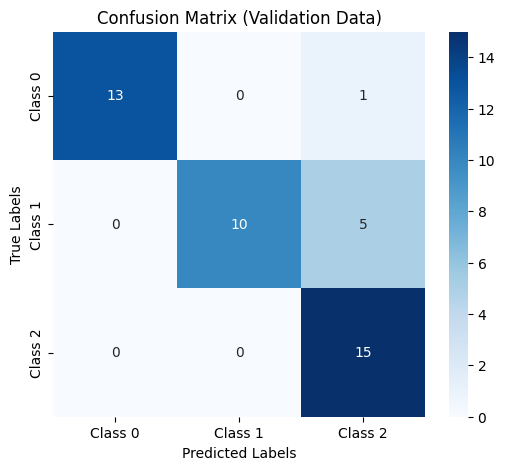

Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      0.93      0.96        14
     Class 1       1.00      0.67      0.80        15
     Class 2       0.71      1.00      0.83        15

    accuracy                           0.86        44
   macro avg       0.90      0.87      0.87        44
weighted avg       0.90      0.86      0.86        44



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict on validation data
y_val_probs = model.predict(val_dataset)  # Get predicted probabilities
y_pred = np.argmax(y_val_probs, axis=1)  # Convert probabilities to class labels

# Extract true labels from validation dataset
y_true = np.concatenate([y.numpy() for _, y in val_dataset])  # Convert tensors to numpy
y_true = np.argmax(y_true, axis=1)  # Convert one-hot labels to class labels

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Validation Data)")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))


In [ ]:
task_labels = [
    "Baseline","HVLT","Stroop",
]

# Generate classification report with actual task names
class_report = classification_report(y_true, y_pred, target_names=task_labels)
print("Updated Classification Report:\n", class_report)


Updated Classification Report:
               precision    recall  f1-score   support

    Baseline       1.00      0.93      0.96        14
        HVLT       1.00      0.67      0.80        15
      Stroop       0.71      1.00      0.83        15

    accuracy                           0.86        44
   macro avg       0.90      0.87      0.87        44
weighted avg       0.90      0.86      0.86        44



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


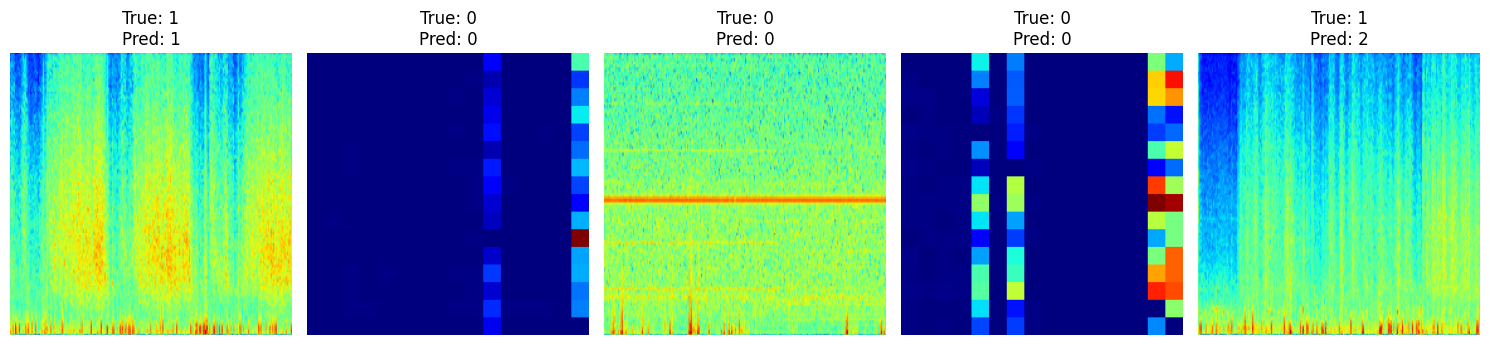

In [ ]:
import random

def predict_random_samples(num_samples=5):
    indices = random.sample(range(len(Y_val)), num_samples)  # Pick random indices

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, idx in enumerate(indices):
        pac_img = X_val_pac[idx]
        spec_img = X_val_spectrogram[idx]
        true_label = np.argmax(Y_val[idx])

        # Predict
        pred = model.predict([np.expand_dims(pac_img, axis=0), np.expand_dims(spec_img, axis=0)])
        pred_label = np.argmax(pred)

        # Show image
        axes[i].imshow(spec_img)  # Show spectrogram image (or PAC if you prefer)
        axes[i].axis('off')
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")

    plt.tight_layout()
    plt.show()

# Run the function
predict_random_samples(num_samples=5)
